In [1]:
import xarray as xr
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

import matplotlib.pyplot as plt

### READ netCDF dataset

In [2]:
#Xarray reads the NETCDF lazily. Only when an operation is needed the values are loaded.
ds_kappa_psi=xr.open_dataset('kappa_psi_dataset.nc')
print(ds_kappa_psi)

<xarray.Dataset> Size: 4GB
Dimensions:  (times: 241734, z: 65, r: 65, shot: 1050)
Coordinates:
  * times    (times) float32 967kB 100.0 180.0 200.0 ... 5.266e+06 5.266e+06
  * shot     (shot) int32 4kB 160016 160067 160072 ... 194915 194959 194993
  * z        (z) float32 260B -1.6 -1.55 -1.5 -1.45 -1.4 ... 1.45 1.5 1.55 1.6
  * r        (r) float32 260B 0.84 0.8666 0.8931 0.9197 ... 2.487 2.513 2.54
Data variables:
    psirz    (times, z, r) float32 4GB ...
    kappa    (times) float32 967kB ...


### USe a small batch of the dataset

In [3]:
#REducing the Dataset size for less memory operations
ds_small=ds_kappa_psi.isel(times=slice(0,50000))

### Define the Variables in our model

In [4]:
y=ds_small['kappa'].values
x=ds_small['psirz'].values

In [5]:
np.shape(x)

(50000, 65, 65)

In [6]:
y_tensor=torch.tensor(y)
x_tensor=torch.tensor(x)
x_tensor = torch.unsqueeze(x_tensor,1) #add channdel dimension (to be consistent with Pytorch standard)
print(x_tensor.shape)
dataset=TensorDataset(x_tensor,y_tensor)

torch.Size([50000, 1, 65, 65])


In [7]:
#split in to train(70%) and test(30%) datasets
train_dataset, test_dataset = random_split(dataset,[0.7,0.3])

In [8]:
batch_size=128
train_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader=DataLoader(train_dataset,batch_size=batch_size)

In [9]:
#calculate the number of 'steps' in the training(testing) loop for future calculations
train_steps=len(train_dataloader.dataset)//batch_size
test_steps=len(test_dataloader.dataset)//batch_size

### Define the model

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=5,kernel_size=5,stride=2,padding=1)
        self.relu1=nn.ReLU()
        self.pool1=nn.MaxPool2d(kernel_size=3,stride=2)
        self.conv2=nn.Conv2d(in_channels=5,out_channels=15,kernel_size=5,stride=2,padding=0)
        self.relu2=nn.ReLU()
        self.pool2=nn.MaxPool2d(kernel_size=2,stride=1)
        self.fc1=nn.Linear(375,100)
        self.relu3=nn.ReLU()
        self.fc2=nn.Linear(100,30)
        self.relu4=nn.ReLU()
        self.fc3=nn.Linear(30,1)

    def forward(self,x):
        #input batch*1*65*65  output batch*5*31*31
        x=self.conv1(x)
        x=self.relu1(x)
        #input batch*5*31*31 output batch*5*15*15
        x=self.pool1(x)
        #input batch*5*15*15 output batch*15*6*6
        x=self.conv2(x)
        x=self.relu2(x)
        #input batch*15*6*6 output batch*15*5*5
        x=self.pool2(x)
        
        x=torch.flatten(x,1)
        x=self.fc1(x)
        x=self.relu3(x)
        x=self.fc2(x)
        x=self.relu4(x)
        x=self.fc3(x)
        return x
    

In [11]:
#hyperparameters
learning_rate=0.001
epochs=5

In [12]:
model=CNN()
optim=torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_fn=nn.MSELoss()
train_loss_list=[]
test_loss_list=[]
for e in range(epochs):
    #train
    train_loss=0
    for fluxsurf,kappa in train_dataloader:
        predict = model(fluxsurf)
        loss=loss_fn(predict,kappa)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss+=loss.item()
    train_loss=train_loss/train_steps #average of losses in the loop
    
    #test
    test_loss=0
    with torch.no_grad():
        for fluxsurf,kappa in test_dataloader:
            predict=model(fluxsurf)
            loss=loss_fn(predict,kappa)
            test_loss+=loss.item()
    test_loss=test_loss/test_steps
            
    print('Current epoch:{},  training loss:{:.4f},  test loss{:.4f}'.format(e+1,train_loss,test_loss))
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

/home/javierhn/miniconda3/envs/fdp-modeling/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/javierhn/miniconda3/envs/fdp-modeling/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Current epoch:1,  training loss:0.2805,  test loss0.0254
Current epoch:2,  training loss:0.0255,  test loss0.0254
Current epoch:3,  training loss:0.0257,  test loss0.0252
Current epoch:4,  training loss:0.0257,  test loss0.0259
Current epoch:5,  training loss:0.0255,  test loss0.0248


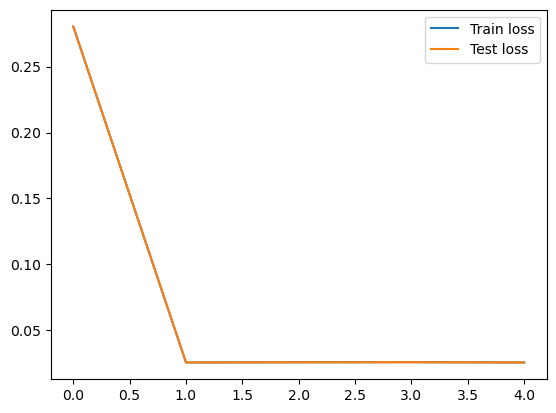

In [13]:
plt.plot(train_loss_list,label='Train loss')
plt.plot(train_loss_list,label='Test loss')
plt.legend()

### Analyze model error

**Kappa (real) histogram**
Most of the values are around 1.7. Huge inbalance

Text(0, 0.5, 'Num. time slices')

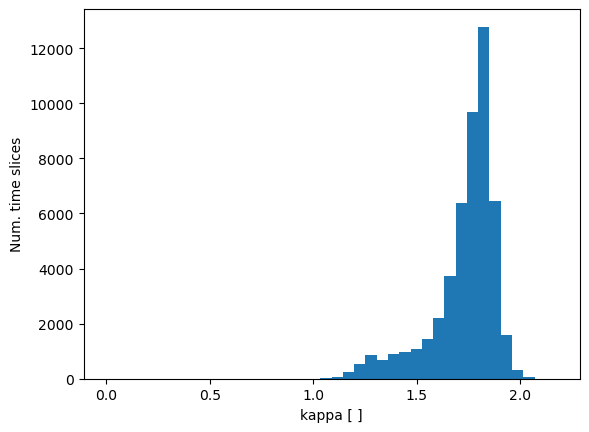

In [14]:
ds_small['kappa'].plot.hist(bins=40)
plt.ylabel('Num. time slices')

In [15]:
real_kappa_list=[]
predict_kappa_list=[]
with torch.no_grad():
    for fluxsurf,kappa in test_dataloader:
        predict=model(fluxsurf)
        loss=loss_fn(predict,kappa)
        predict=torch.squeeze(predict,1)
        real_kappa_list.extend(kappa.tolist())
        predict_kappa_list.extend(predict.tolist())
real_kappa=np.array(real_kappa_list)
predict_kappa=np.array(predict_kappa_list)

[1.6        1.63333333 1.66666667 1.7        1.73333333 1.76666667
 1.8        1.83333333 1.86666667 1.9       ]


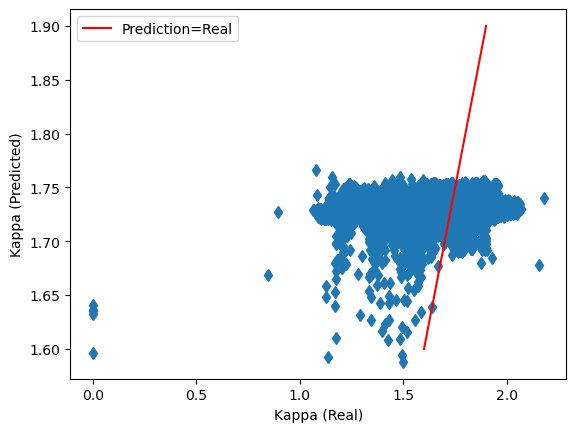

In [20]:
plt.plot(real_kappa,predict_kappa,linestyle='None',marker='d')
aux_kappa_real=np.linspace(1.6,1.9,10)
aux_kappa_predict=np.linspace(1.6,1.9,10)
print(aux_kappa_predict)
plt.plot(aux_kappa_real,aux_kappa_predict,linestyle='-',color='r',label='Prediction=Real')
plt.xlabel('Kappa (Real)')
plt.ylabel('Kappa (Predicted)')
plt.legend()

In [17]:
#mean absolute error
mae=np.abs(real_kappa-predict_kappa)

Text(0, 0.5, 'MAE')

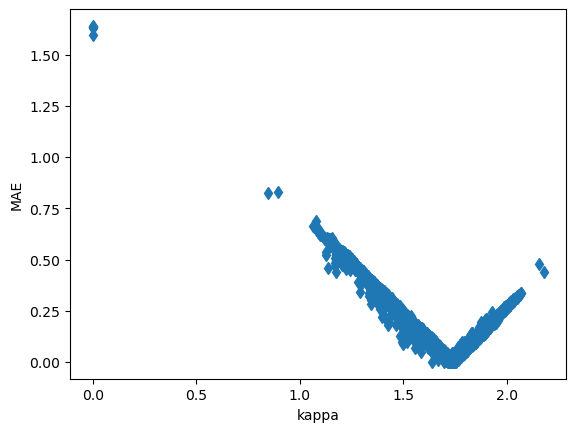

In [18]:
plt.plot(real_kappa,mae,linestyle='None',marker='d')
plt.xlabel('kappa')
plt.ylabel('MAE')

Text(0.5, 0, 'MAE')

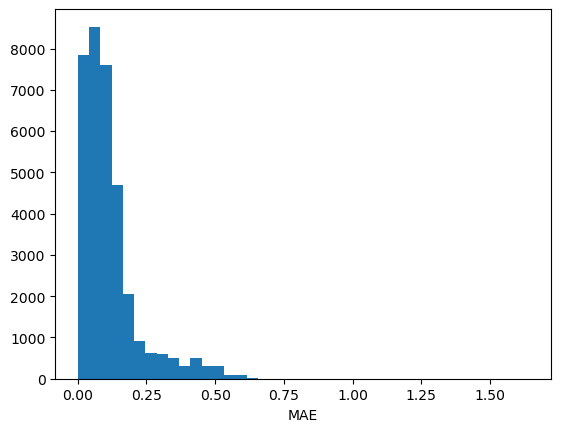

In [19]:
plt.hist(mae,bins=40)
plt.xlabel('MAE')